In [420]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import ruptures as rpt
from functools import partial
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.seasonal import seasonal_decompose

from bayesian_changepoint_detection.bayesian_changepoint_detection.priors import const_prior
import bayesian_changepoint_detection.bayesian_changepoint_detection.offline_likelihoods as offline_ll
from bayesian_changepoint_detection.bayesian_changepoint_detection.generate_data import generate_normal_time_series
from bayesian_changepoint_detection.bayesian_changepoint_detection.bayesian_models import offline_changepoint_detection

warnings.filterwarnings("ignore")

In [421]:
def vis(pred_error, seg_points, method):
    if len(pred_error) not in seg_points:
        seg_points.append(len(pred_error))
    rpt.display(pred_error, seg_points)
    plt.title(method)
    plt.show()

In [422]:
def pelt(pred_error, penality = 20):
    
    model = rpt.Pelt(model="rbf").fit(pred_error)
    seg_points = model.predict(pen=penality)
    
    return seg_points

In [423]:
def bocp(pred_error, percentile=75):
    
    prior_function = partial(const_prior, p=1/(len(pred_error) + 1))
    Q, P, Pcp = offline_changepoint_detection(pred_error, prior_function ,offline_ll.StudentT(),truncate=-40)
    
    prob = np.exp(Pcp).sum(0)
    threshold = np.percentile(prob, percentile, axis=0)
    
    seg_points = list(np.where(prob > threshold)[0])
    
    return seg_points

In [424]:
def change_rate(pred_error, window_size = 20, percentile=75):
    
    change_rate_array = []
    for i in range(len(pred_error) - window_size - 1):
        window = []
        for j in range(i, i + window_size):
            window.append(pred_error[j])
        change_rate = abs(max(window) - min(window)) / (min(window) + 0.005)
        change_rate_array.append(change_rate)
        
    change_rate_array_norm = (change_rate_array - min(change_rate_array)) / (max(change_rate_array) - min(change_rate_array))
    threshold = np.percentile(change_rate_array_norm, percentile, axis=0)
    
    seg_points = list(np.where(change_rate_array_norm > threshold)[0])
    
    return seg_points

In [425]:
def read_data(path):
    
    f = open(path, "r")
    data = f.readlines()
    prediction_error = np.array([float(err[:-2]) for err in data])
    f.close()
    
    return prediction_error

In [426]:
path1 = "./KnowledgeGraphChangePointDetection/results/stream_FB15K-237_testdata1.txt"
prediction_error1 = read_data(path1)

path2 = "./KnowledgeGraphChangePointDetection/results/stream_FB15K-237_testdata2.txt"
prediction_error2 = read_data(path2)

path3 = "./KnowledgeGraphChangePointDetection/results/stream_FB15K-237_testdata3.txt"
prediction_error3 = read_data(path3)

In [427]:
error_list = [prediction_error1, prediction_error2, prediction_error3]

In [440]:
signals = error_list[1]

In [448]:
seg_points_pelt = pelt(signals, penality=20)

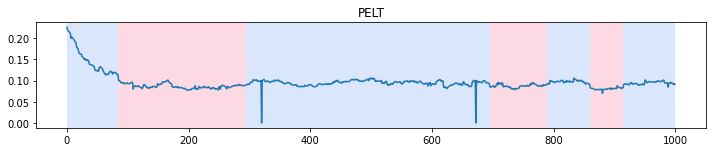

In [449]:
vis(signals, seg_points_pelt, method="PELT")

In [450]:
seg_points_bocp = bocp(signals, percentile=95)

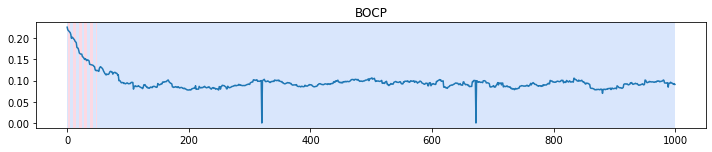

In [451]:
vis(signals, seg_points_bocp, method="BOCP")

In [460]:
seg_points_threshold = change_rate(signals, window_size=10, percentile=99)

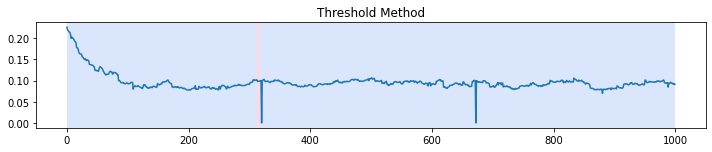

In [462]:
vis(signals, seg_points_threshold, method="Threshold Method")

### ARIMA

In [243]:
"""
# Read the AirPassengers dataset
airline = pd.read_csv('AirPassengers.csv', index_col ='Month', parse_dates = True)
  
# Print the first five rows of the dataset
airline.head()

result = seasonal_decompose(pd.DataFrame(prediction_error), model ='multiplicative')
  
# ETS plot 
result.plot()
plt.show()

# Fit auto_arima function to AirPassengers dataset
stepwise_fit = auto_arima(airline['#Passengers'], start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
  
stepwise_fit.summary()

# Split data into train / test sets
train = airline.iloc[:len(airline)-12]
test = airline.iloc[len(airline)-12:] # set one year(12 months) for testing
  
# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
model = SARIMAX(train['#Passengers'], 
                order = (0, 1, 1), 
                seasonal_order =(2, 1, 1, 12))
  
result = model.fit()
result.summary()

start = len(train)
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
# plot predictions and actual values
predictions.plot(legend = True)
test['#Passengers'].plot(legend = True)

# Calculate root mean squared error
rmse(test["#Passengers"], predictions)
  
# Calculate mean squared error
mean_squared_error(test["#Passengers"], predictions)
"""

'\n# Read the AirPassengers dataset\nairline = pd.read_csv(\'AirPassengers.csv\', index_col =\'Month\', parse_dates = True)\n  \n# Print the first five rows of the dataset\nairline.head()\n\nresult = seasonal_decompose(pd.DataFrame(prediction_error), model =\'multiplicative\')\n  \n# ETS plot \nresult.plot()\nplt.show()\n\n# Fit auto_arima function to AirPassengers dataset\nstepwise_fit = auto_arima(airline[\'#Passengers\'], start_p = 1, start_q = 1,\n                          max_p = 3, max_q = 3, m = 12,\n                          start_P = 0, seasonal = True,\n                          d = None, D = 1, trace = True,\n                          error_action =\'ignore\',   # we don\'t want to know if an order does not work\n                          suppress_warnings = True,  # we don\'t want convergence warnings\n                          stepwise = True)           # set to stepwise\n  \nstepwise_fit.summary()\n\n# Split data into train / test sets\ntrain = airline.iloc[:len(airline)-